In [1]:
from model.BrownianBridge.base.modules.diffusionmodules.openaimodel import UNetModel 
from datasets.custom import CustomAlignedDataset
from torch.utils.data import DataLoader
import sampling_method as sm
from ema import EMA
from latent_space import LDM

import torch
import yaml
from utils import dict2namespace
from tqdm.autonotebook import tqdm

device = 'cuda:3'
batch_size = 8
f = open('cf.yaml', 'r')
ckpt_path = './results/BBDM_SDE_ema/best_ckpt.pth'
ckpt = torch.load(ckpt_path)

use_ema = True


/root/anaconda3/envs/BBDM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config

dict_config = yaml.load(f, Loader=yaml.FullLoader)
nconfig = dict2namespace(dict_config)

# ldm
latent_encoder = LDM(nconfig.model.VQGAN.params)
latent_encoder = latent_encoder.to(device)

ckpt.keys()

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
Restored from /workdir/carrot/vqgan/vq1_3_69.ckpt
load vqgan from /workdir/carrot/vqgan/vq1_3_69.ckpt


dict_keys(['best_model', 'epoch', 'optimizer', 'scheduler', 'ema'])

In [4]:

# dataset
test_dataset = CustomAlignedDataset(nconfig.data.dataset_config, 'test')

# score func model
score_model = UNetModel(**vars(nconfig.model.BB.params.UNetParams))
    
# load pretrained model
score_model.load_state_dict(ckpt['best_model']) 
score_model = score_model.to(device)

if use_ema:
    emA = EMA(0.999)
    emA.shadow = ckpt['ema']
    emA.reset_device(score_model)
    emA.apply_shadow(score_model)

  
# sampling with Numer SDE Solvers
num_steps =  500#@param {'type':'integer'}


def marginal_prob_std(t):
  """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.
  Args:
    t: A vector of time steps.
  Returns:
    The standard deviation.
  """
  t = torch.tensor(t, device=device)
  # return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))
  std = torch.sqrt(2. * (t - t ** 2))
  
  return std 

def diffusion_coeff(t):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

  Returns:
    The vector of diffusion coefficients.
  """
  diff = torch.ones_like(t, device=device)
  diff = diff * torch.tensor(2.0).sqrt()
  # return torch.tensor(sigma**t, device=device)
  return diff 

def drift_coeff(t): 
  # return batch of 1 / (1 - t)
  drift = torch.ones_like(t, device=device)
  # drift = drift / (1 - t + 1e-3)
  # drift = drift / (1 - t)
  drift = drift * torch.tensor(1.0)
  return drift

test_loader = DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     num_workers=8,
                                     drop_last=True)

In [9]:
result_path = './result_path'
max_pixel_pet = nconfig.data.dataset_config.max_pixel_ori

In [10]:
import os
k = 0 
sampler = sm.pc_sampler
for batch in tqdm(test_loader):
  (x, x_name), (y, y_name) = batch
  y = y.to(device)
  y_latent = latent_encoder.encode(y)
  samples = sampler(y_latent, score_model, marginal_prob_std, drift_coeff, diffusion_coeff, batch_size=y.shape[0], num_steps=1000, device=device)
  samples_1 = latent_encoder.decode(samples)
  for i in range(batch_size): 
    image = samples_1[i]
    sample_path = os.path.join(result_path, x_name[i])
    image = image.mul_(0.5).add_(0.5).clamp_(0, 1.)
    image = image.mul_(max_pixel_pet).add_(0.2).clamp_(0, max_pixel_pet).permute(1, 2, 0).to('cpu').numpy()
    file_name = x_name[i]
    print(sample_path)
  k += 1 
  if k == 4: 
    break
  # samples_1.clamp(0.0, 1.0)
  # break

  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_18359/1313187731.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  1%|          | 1/125 [00:59<2:02:20, 59.20s/it]

./result_path/9000
./result_path/9001
./result_path/9002
./result_path/9003
./result_path/9004
./result_path/9005
./result_path/9006
./result_path/9007


  2%|▏         | 2/125 [01:59<2:03:07, 60.06s/it]

./result_path/9008
./result_path/9009
./result_path/9010
./result_path/9011
./result_path/9012
./result_path/9013
./result_path/9014
./result_path/9015


  2%|▏         | 3/125 [03:03<2:05:17, 61.62s/it]

./result_path/9016
./result_path/9017
./result_path/9018
./result_path/9019
./result_path/9020
./result_path/9021
./result_path/9022
./result_path/9023


  2%|▏         | 3/125 [04:06<2:47:19, 82.29s/it]

./result_path/9024
./result_path/9025
./result_path/9026
./result_path/9027
./result_path/9028
./result_path/9029
./result_path/9030
./result_path/9031


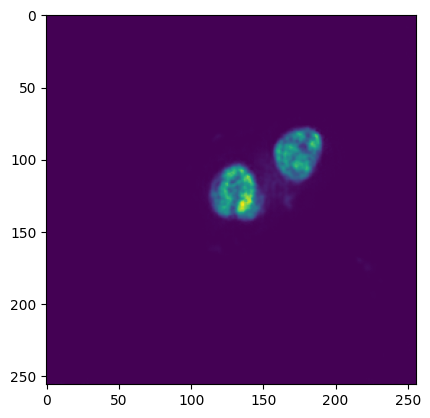

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image)

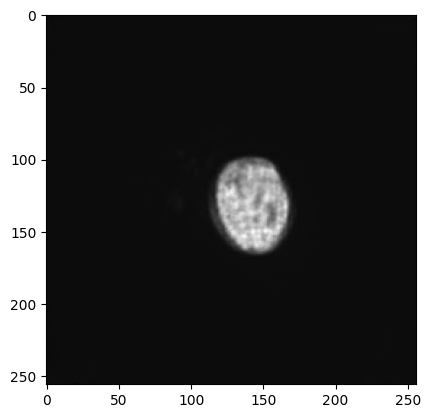

In [23]:
# show samples
import matplotlib.pyplot as plt
import numpy as np

np_img = samples_1[6].cpu().detach().numpy()
plt.imshow(np.transpose(np_img, (1, 2, 0)), cmap='gray')    


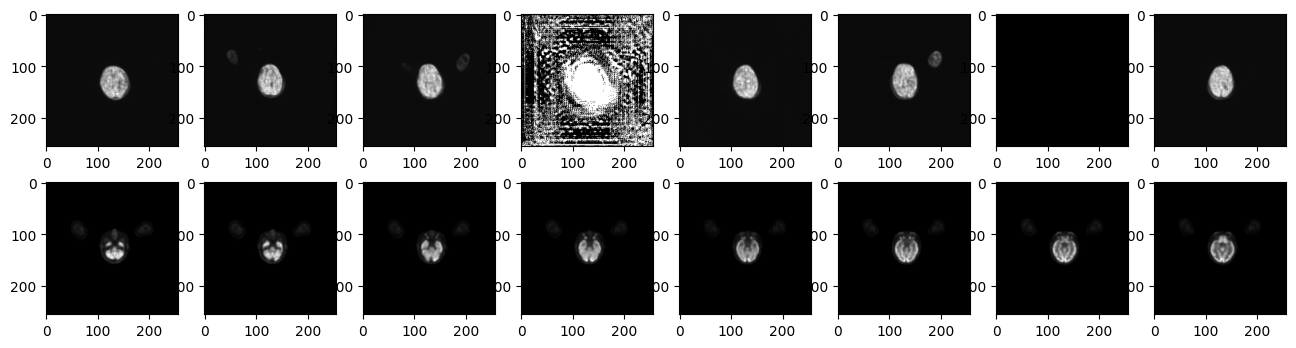

In [39]:
# show batch of samples and original images
import matplotlib.pyplot as plt
import numpy as np

np_img = samples_1.cpu().detach().numpy()
np_img = np.transpose(np_img, (0, 2, 3, 1))

gt = x.cpu().detach().numpy()
gt = np.transpose(gt, (0, 2, 3, 1))

fig, ax = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
  ax[0, i].imshow(np_img[i], cmap='gray')
  ax[1, i].imshow(gt[i] , cmap='gray')

In [37]:
image = samples_1[3]
# sample_path = os.path.join(result_path, x_name[i])
image = image.mul_(0.5).add_(0.5).clamp_(0, 1.)
image = image.mul_(32767).add_(0.2).clamp_(0, 32767).permute(1, 2, 0).to('cpu').numpy()


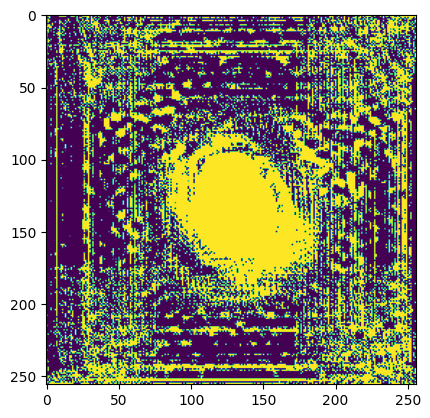

In [38]:
plt.imshow(image)

In [31]:
image1 = samples_1[6]
# sample_path = os.path.join(result_path, x_name[i])
image1 = image1.mul_(0.5).add_(0.5).clamp_(0, 1.)
image1 = image1.mul_(32767).add_(0.2).clamp_(0, 32767).permute(1, 2, 0).to('cpu').numpy()


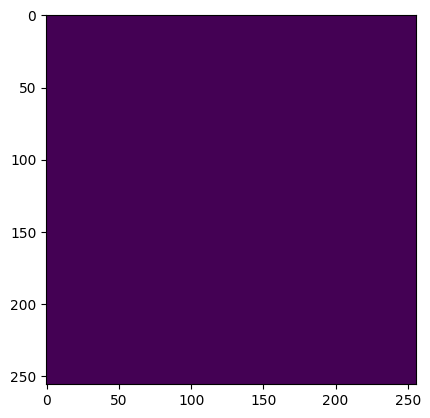

In [32]:
plt.imshow(image1)

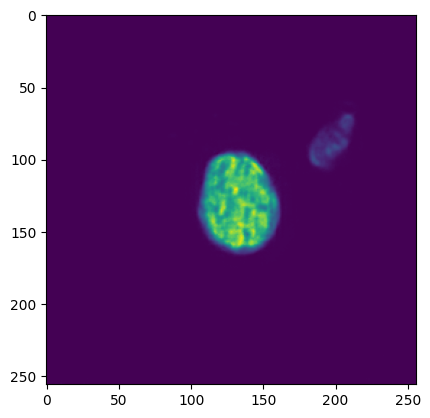

In [18]:
import numpy as np
np_img = np.load('/workdir/ssd2/nguyent_petct/tiennh/BBDM_SDE/results/BBDM_SDE_ema/500/9009.npy')
plt.imshow(np_img)